# INN Hotels Project

## Context

A significant number of hotel bookings are called-off due to cancellations or no-shows. The typical reasons for cancellations include change of plans, scheduling conflicts, etc. This is often made easier by the option to do so free of charge or preferably at a low cost which is beneficial to hotel guests but it is a less desirable and possibly revenue-diminishing factor for hotels to deal with. Such losses are particularly high on last-minute cancellations. 

The new technologies involving online booking channels have dramatically changed customers’ booking possibilities and behavior. This adds a further dimension to the challenge of how hotels handle cancellations, which are no longer limited to traditional booking and guest characteristics. 

The cancellation of bookings impact a hotel on various fronts:
* Loss of resources (revenue) when the hotel cannot resell the room.
* Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms.
* Lowering prices last minute, so the hotel can resell a room, resulting in reducing the profit margin.
* Human resources to make arrangements for the guests.

## Objective
The increasing number of cancellations calls for a Machine Learning based solution that can help in predicting which booking is likely to be canceled. INN Hotels Group has a chain of hotels in Portugal, they are facing problems with the high number of booking cancellations and have reached out to your firm for data-driven solutions. You as a data scientist have to analyze the data provided to find which factors have a high influence on booking cancellations, build a predictive model that can predict which booking is going to be canceled in advance, and help in formulating profitable policies for cancellations and refunds.

## Data Description
The data contains the different attributes of customers' booking details. The detailed data dictionary is given below.


**Data Dictionary**

* Booking_ID: unique identifier of each booking
* no_of_adults: Number of adults
* no_of_children: Number of Children
* no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
* no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
* type_of_meal_plan: Type of meal plan booked by the customer:
    * Not Selected – No meal plan selected
    * Meal Plan 1 – Breakfast
    * Meal Plan 2 – Half board (breakfast and one other meal)
    * Meal Plan 3 – Full board (breakfast, lunch, and dinner)
* required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
* room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
* lead_time: Number of days between the date of booking and the arrival date
* arrival_year: Year of arrival date
* arrival_month: Month of arrival date
* arrival_date: Date of the month
* market_segment_type: Market segment designation.
* repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
* no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
* no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
* avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
* no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
* booking_status: Flag indicating if the booking was canceled or not.

In [1]:
#Import all libraries necessary for manipulation, visualization, and modeling.

import warnings

warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# setting the precision of floating numbers to 5 decimal points
pd.set_option("display.float_format", lambda x: "%.5f" % x)

# Library to split data
from sklearn.model_selection import train_test_split

# To build model for prediction
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# To tune different models
from sklearn.model_selection import GridSearchCV

#this package looks at all the columns in your dataframe and identifies possible cleaning tasks that need to be done, saving a massive amount of time and code.
from pandas_dq import dq_report as dqr

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)

Imported pandas_dq (1.12). Always upgrade to get latest features.



## Data Overview

In [2]:
#import Data
data = pd.read_csv("INNHotelsGroup.csv")
print(data.head())
data.info()

  Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   
1        Room_

## Exploratory Data Analysis (EDA)

**General Questions**:
1. What are the busiest months in the hotel?
2. Which market segment do most of the guests come from?
3. Hotel rates are dynamic and change according to demand and customer demographics. What are the differences in room prices in different market segments?
4. What percentage of bookings are canceled? 
5. Repeating guests are the guests who stay in the hotel often and are important to brand equity. What percentage of repeating guests cancel?
6. Many guests have special requirements when booking a hotel room. Do these requirements affect booking cancellation?

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space', 'lead_time',
       'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests'],
      dtype='object')


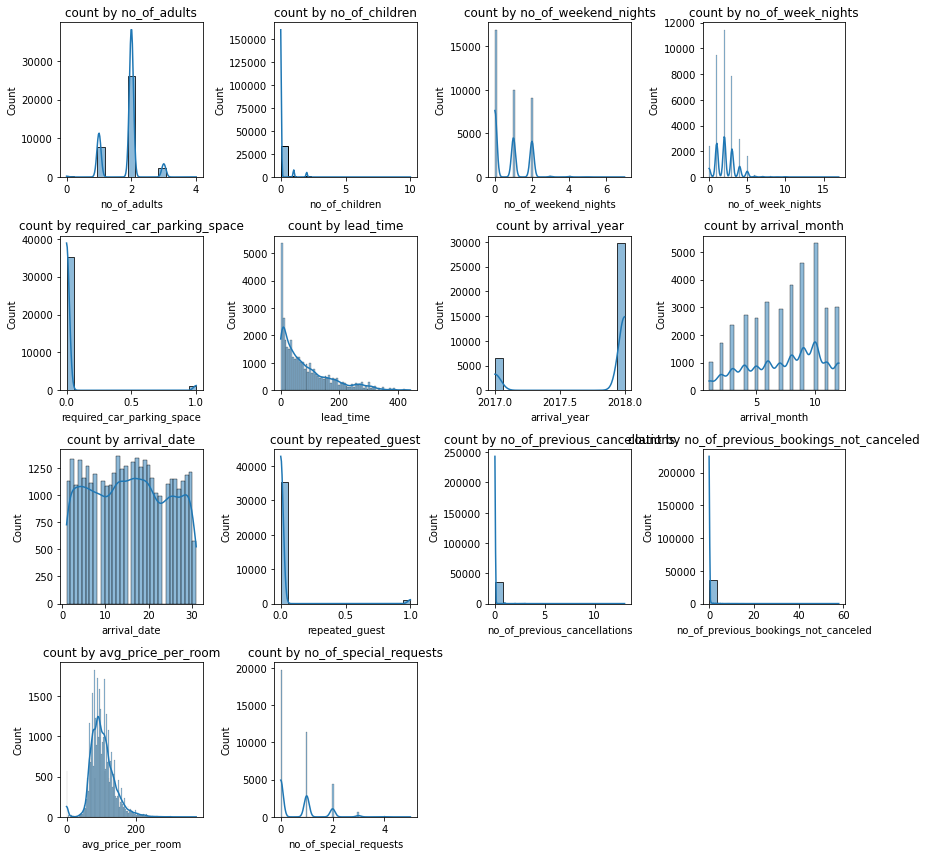

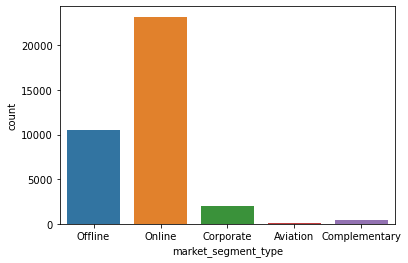

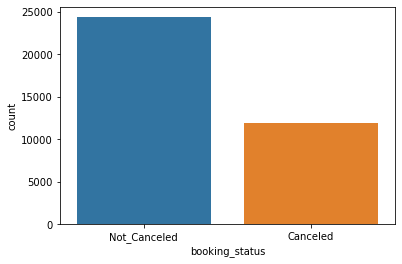

32.76


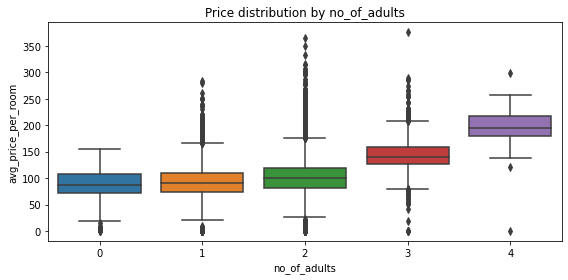

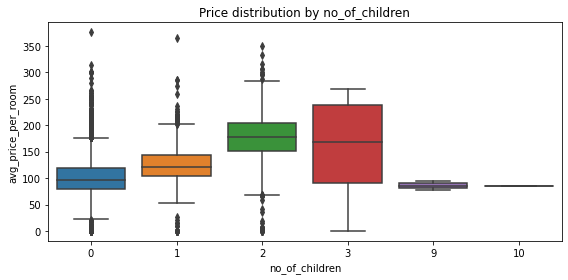

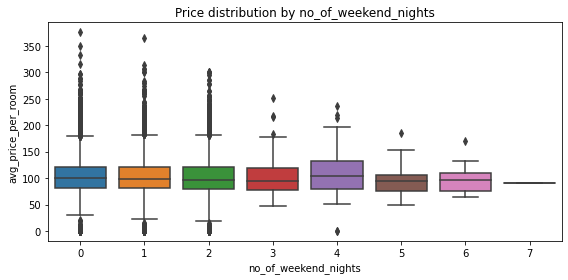

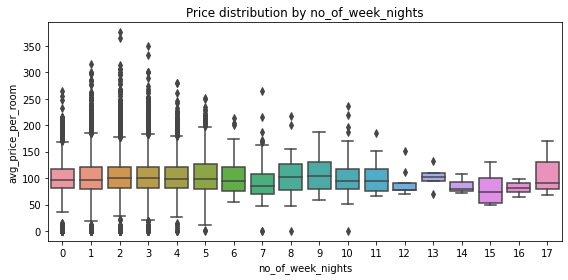

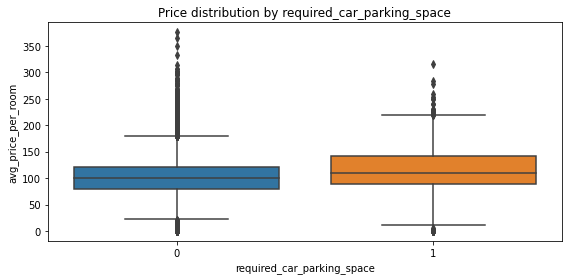

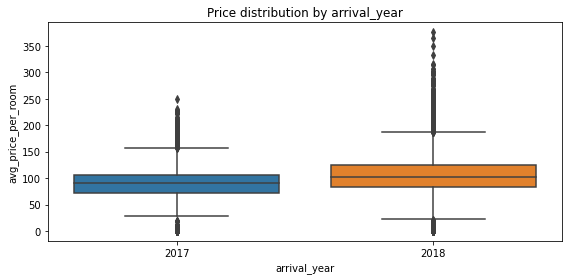

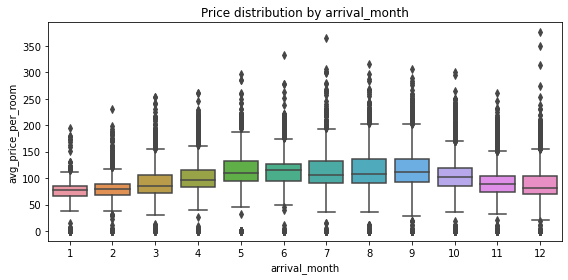

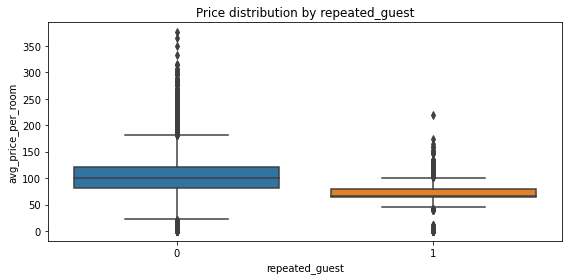

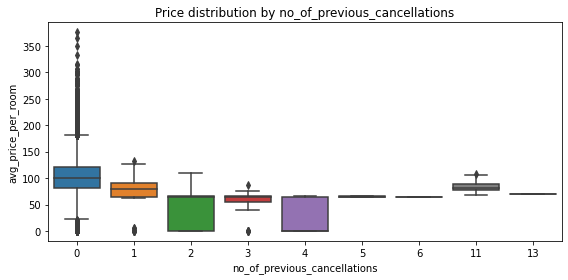

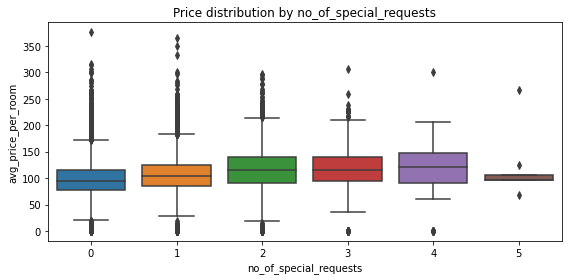

Text(0.5, 1.0, 'Price vs. Lead Time')

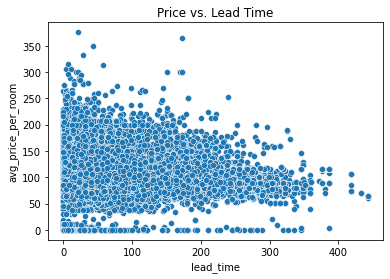

In [3]:
#Univariate analysis

#Drop price Outlier of one room over 500$ out of 36000+ bookings (outlier)
data = data.drop(data[data['avg_price_per_room'] > 400].index)
#create dataframe with only numeric colunms
numeric_columns= data.select_dtypes(include='number').columns
num_data=data[numeric_columns]
print(numeric_columns)

#create empty figure to store graphs
fig = plt.figure(figsize=(12, 12))  # Set the figure size to 12x12 inches

#create loops to look at countplots and boxplots of all individual numeric variables 
for i, var in enumerate(num_data):
    ax = fig.add_subplot(4, 4, i+1)  # Create a subplot for each variable
    sns.histplot(data=data, x=var, kde=True, ax=ax)
    ax.set_title('count by {}'.format(var))  # Set the title
    plt.tight_layout()    
plt.show()

#look at the number of customers in each market segment
sns.countplot(data=data, x=data['market_segment_type'])
plt.show()

#create a countplot to count number of bookings by booking status class
sns.countplot(data=data, x=data['booking_status'])
plt.show()
cancel_count= len(data[data['booking_status']=='Canceled'])
total_count=len(data['booking_status'])
percent_cancel= (cancel_count/total_count)*100
print(round(percent_cancel,2))

#This dataframe includes only the categorical variables that i want to investigate in relationship to room price.
num_data2=num_data.drop(['avg_price_per_room', 'no_of_previous_bookings_not_canceled', 'lead_time', 'arrival_date'], axis=1)
#drop 

for var1 in num_data2:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=data, x=var1, y=data['avg_price_per_room'])
    plt.title('Price distribution by {}'.format(var1))
    plt.tight_layout() 
plt.show()

#price vs lead time 
sns.scatterplot(x=data['lead_time'], y=data['avg_price_per_room'])
plt.title('Price vs. Lead Time')

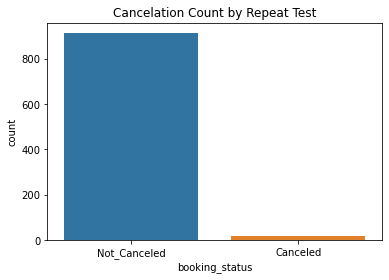

16
36274
1.72
3340
16498
20.24


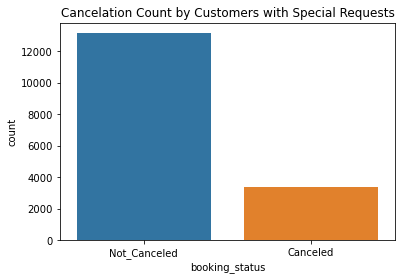

In [4]:
#investigate cancelations from repeat guests 
repeat_guests=data[data['repeated_guest']>0]
sns.countplot(data=repeat_guests, x='booking_status') 
plt.title("Cancelation Count by Repeat Test")
plt.show()

#calculate the percentage of cancelations from repeat guests 
cancel_count_repeat2= len(repeat_guests[repeat_guests['booking_status']=='Canceled'])
print(cancel_count_repeat2)
total_count2=len(repeat_guests['booking_status'])
print(total_count)
percent_cancel2= (cancel_count_repeat2/total_count2)*100
print(round(percent_cancel2, 2))

specials=data[data['no_of_special_requests']>0]
sns.countplot(data=specials, x='booking_status')
plt.title("Cancelation Count by Customers with Special Requests")

cancel_count_specials= len(specials[specials['booking_status']=='Canceled'])
print(cancel_count_specials)
total_count3=len(specials['booking_status'])
print(total_count3)
percent_cancel3= (cancel_count_specials/total_count3)*100
print(round(percent_cancel3, 2))

#### Observations: 
1. What are the busiest months in the hotel?
   - We can see that October is the busiest month by number of arrivals compared to other months
2. Which market segment do most of the guests come from?
   - Most guests are coming from online, followed by offline, corporate, complimentary, and aviation
3. Hotel rates are dynamic and change according to demand and customer demographics. What are the differences in room prices in different market segments?
   - We can see that customers coming from the online and aviation segments are typically higher than corporate and offline segments. This being said the difference isnt massive  
4. What percentage of bookings are cancelled?
   - 32.76% of all bookings are canceled
5. Repeating guests are the guests who stay in the hotel often and are important to brand equity. What percentage of repeating guests cancel?
   -  The percentage of cancelations be repeat guests is 1.72% of the total repeat guests. Much lower than the percentage for all guests
6. Many guests have special requirements when booking a hotel room. Do these requirements affect booking cancellation?
    - 20.24% of guests with special requests canceled their orders which is less than the 36.76% for all guests. therefore they seem to cancel at a lower rate when they have special requests.
    
Other:
- It seems that those who have a history of cancelations on average get lower prices for their hotel rooms. This indicates that it is in customers best interest to cancel rooms if they are unhappy with the ammenities as they can likely find lower prices. Also, those who cancel rooms are also likely the type of people who will continue their hotel search to find the best price. 
- Repeat guests at INN hotels have lower average room costs compared to first time customers. This could be due to membership deals or simply the fact that these repeat customers are familiar with the hotels policies therefore can find the best deals. We would need more information to make a determination on this.  
  

## Data Preprocessing

- Missing value treatment 
- Feature engineering 
- Outlier detection and treatment 
- Preparing data for modeling 
- Any other preprocessing steps

In [5]:
#this pandas package and function imported above automatically looks for issues in each of your columns and give recommendations on how to deal with them.
result= dqr(data=data, csv_engine='pandas', verbose=1)

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Booking_ID,object,0.000000,100,INN00001,INN36275,"Possible ID colum: drop before modeling process., 36274 rare categories: Too many to list. Group them into a single category or drop the categories., high cardinality with 36274 unique values: Use hash encoding or embedding to reduce dimension."
no_of_adults,int64,0.000000,0,0,4,has 10167 outliers greater than upper bound (2.0) or lower than lower bound(2.0). Cap them or remove them.
no_of_children,int64,0.000000,0,0,10,has 2698 outliers greater than upper bound (0.0) or lower than lower bound(0.0). Cap them or remove them.
no_of_weekend_nights,int64,0.000000,0,0,7,has 21 outliers greater than upper bound (5.0) or lower than lower bound(-3.0). Cap them or remove them.
no_of_week_nights,int64,0.000000,0,0,17,has 324 outliers greater than upper bound (6.0) or lower than lower bound(-2.0). Cap them or remove them.
type_of_meal_plan,object,0.000000,0,Meal Plan 1,Not Selected,1 rare categories: ['Meal Plan 3']. Group them into a single category or drop the categories.
required_car_parking_space,int64,0.000000,0,0,1,has 1124 outliers greater than upper bound (0.0) or lower than lower bound(0.0). Cap them or remove them.
room_type_reserved,object,0.000000,0,Room_Type 1,Room_Type 7,"5 rare categories: ['Room_Type 6', 'Room_Type 2', 'Room_Type 5', 'Room_Type 7', 'Room_Type 3']. Group them into a single category or drop the categories."
lead_time,int64,0.000000,0,0,443,has 1331 outliers greater than upper bound (289.5) or lower than lower bound(-146.5). Cap them or remove them.
arrival_year,int64,0.000000,0,2017,2018,has 6514 outliers greater than upper bound (2018.0) or lower than lower bound(2018.0). Cap them or remove them.


#### Outlier detection 

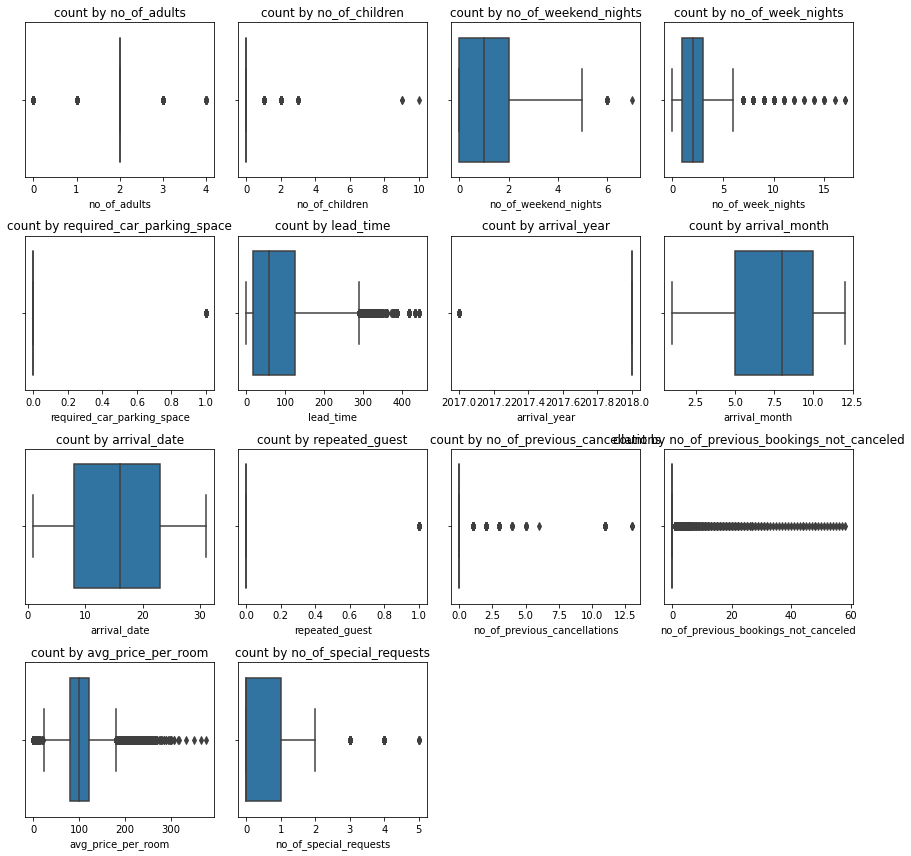

In [6]:
#Create empty figure to store graphs
fig = plt.figure(figsize=(12, 12))  # Set the figure size to 12x12 inches

#create loops to look at countplots and boxplots of all individual numeric variables 
for i, var in enumerate(num_data):
    ax = fig.add_subplot(4, 4, i+1)  # Create a subplot for each variable
    sns.boxplot(data=data, x=var)
    ax.set_title('count by {}'.format(var))  # Set the title
    plt.tight_layout()    
plt.show()

In [7]:
#Feature engineering 1 (Drop booking ID column)

#Lets drop the booking ID column as it isnt usefull for building our model
data = data.drop(['Booking_ID'], axis=1)

In [8]:
#Feature engineering 2 (Convert booking status to Binary)

#convert the booking status column to binary 0 and 1 variables instead of object outputs so the model function can use it
data["booking_status"] = data["booking_status"].apply(
    lambda x: 1 if x == "Canceled" else 0
)

### REMEMBER that 1 in booking_status means canceled and 0 means not canceled. 

In [9]:
#Preparing data for modeling (Split into predictor and response variables)
x= data.drop(['booking_status'], axis=1)
y= data['booking_status']

# adding constant
x = sm.add_constant(x) ## Complete the code to add constant to X 

## Complete the code to create dummies for X
x = pd.get_dummies(x, columns=x.select_dtypes(include=['object','category']).columns.tolist(), drop_first=True)

# Splitting data in train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) ## Complete the code to split the data into train test in the ratio 70:30 with random_state = 1

#### Observations:
  - None of the fields have any null values and therefore no manipulation needs to take place however we dropped the Booking_ID column as it isnt useful.
  - While there are a number of fields with outliers, none of these outliers indicate issues with the data or incorrect values (based on the variable in question) and therefore they dont need to be removed. 
  - The only row that was dropped was a row with a room price of over 500$ for one night.  out of 36000+ results this was the only booking over 500 so I assumed it to be a mistake and dropped it before EDA above.

## Building a Logistic Regression model

In [10]:
#Here we will create some functions that helps build confusion matrices and compute matrix of our classification model.

# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification_statsmodels(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred_temp = model.predict(predictors) > threshold
    # rounding off the above values to get classes
    pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [11]:
#Defining a function to plot the confusion_matrix of a classification model
def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    y_pred = model.predict(predictors) > threshold
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [12]:
#Fitting logistic regression model
logit = sm.Logit(y_train, x_train.astype(float))
lg = logit.fit() ## Complete the code to fit logistic regression

         Current function value: 0.423510
         Iterations: 35


In [13]:
#Print the logistic regression summary
print(lg.summary())

                           Logit Regression Results                           
Dep. Variable:         booking_status   No. Observations:                25391
Model:                          Logit   Df Residuals:                    25363
Method:                           MLE   Df Model:                           27
Date:                Tue, 30 May 2023   Pseudo R-squ.:                  0.3325
Time:                        09:53:59   Log-Likelihood:                -10753.
converged:                      False   LL-Null:                       -16110.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                 -928.9090    121.590     -7.640      0.000   -1167.222    -690.596
no_of_adults                             0.1219      

## Model performance evaluation

In [14]:
#Predicting on training set
#Default threshold is 0.5, if predicted probability is greater than 0.5 the observation will be classified as 1
pred_train = lg.predict(x_train) > 0.5
pred_train = np.round(pred_train)

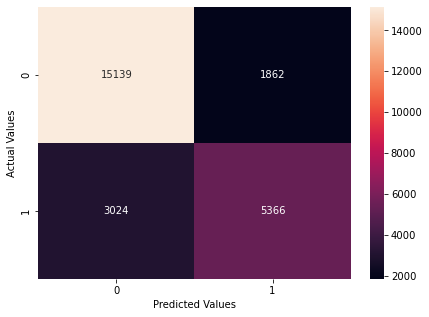

In [15]:
cm = confusion_matrix(y_train, pred_train)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="g")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

### Checking Multicollinearity
- In order to make statistical inferences from a logistic regression model, it is important to ensure that there is no multicollinearity present in the data.

In [16]:
#These results are for a threshhold of 0.5
print("Training performance:")
model_performance_classification_statsmodels(lg, x_train, y_train)

Training performance:


,Accuracy,Recall,Precision,F1
0,0.80757,0.63957,0.74239,0.68716


#### Observations
- These results are a promissing starting point as we have decent accuracy.
- We should focus on reducing our F1 as this is a measure of false negatives and false positives and we want to make sure that customers arent being inaccurately classified as with regard to canceling or not canceling bookings.
- Both false negatives and fales positives are equally damaging to our results in this model therefore we cannot focus on minimizing just one of them. 
- Next lets remove variables with high p values or signs of multicoliniarity to see how the model responds 

In [17]:
 # we will define a function to check VIF
def checking_vif(predictors):
    vif = pd.DataFrame()
    vif["feature"] = predictors.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(predictors.values, i)
        for i in range(len(predictors.columns))
    ]
    return vif

In [18]:
checking_vif(x_train)

,feature,VIF
0,const,39717847.05255
1,no_of_adults,1.33843
2,no_of_children,1.97333
3,no_of_weekend_nights,1.06735
4,no_of_week_nights,1.09654
5,required_car_parking_space,1.03523
6,lead_time,1.39338
7,arrival_year,1.43257
8,arrival_month,1.27872
9,arrival_date,1.00637


#### Observations
- The VIF values are under 5 for all variables except for the market_segment dumy variables.  These should be removed one by one to see how each removal effects model performance. 

In [19]:
#Drop the market_segment_type_Online variable first as it has highest VIF
col_to_drop = 'market_segment_type_Online' 
x_train2 = x_train.loc[:, ~x_train.columns.str.startswith(col_to_drop)] 
x_test2 = x_test.loc[:, ~x_test.columns.str.startswith(col_to_drop)] 

checking_vif(x_train2)

,feature,VIF
0,const,39647590.04236
1,no_of_adults,1.32332
2,no_of_children,1.97255
3,no_of_weekend_nights,1.06661
4,no_of_week_nights,1.09526
5,required_car_parking_space,1.03506
6,lead_time,1.38917
7,arrival_year,1.43036
8,arrival_month,1.27803
9,arrival_date,1.00636


In [20]:
# fitting logistic regression model
logit = sm.Logit(y_train, x_train2.astype(float))
lg = logit.fit() ## Complete the code to fit logistic regression

         Current function value: 0.423552
         Iterations: 35


In [21]:
print("Training performance:")
model_performance_classification_statsmodels(lg, x_train2, y_train)

Training performance:


,Accuracy,Recall,Precision,F1
0,0.80725,0.63921,0.74177,0.68668


#### Observations
- The removal of the 'market_segment_type_Online' all VIF values are below 5 which indicates little to no multicolliniarity. 
- Reruning the model after dropping the variable yielded similar training performance values
- We can now move on to removing variables with large p-values.   

## Remove High P-value Variables

In [22]:
print(lg.summary())

                           Logit Regression Results                           
Dep. Variable:         booking_status   No. Observations:                25391
Model:                          Logit   Df Residuals:                    25364
Method:                           MLE   Df Model:                           26
Date:                Tue, 30 May 2023   Pseudo R-squ.:                  0.3324
Time:                        09:54:01   Log-Likelihood:                -10754.
converged:                      False   LL-Null:                       -16110.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                 -936.7741    121.444     -7.714      0.000   -1174.801    -698.748
no_of_adults                             0.1150      

#### Observations
- There are several variables with high P-values including 'market_segment_type_Complementary', 'room_type_reserved_Room_Type 3', 'type_of_meal_plan_Meal Plan 2 '
- We will drop the variables with the highest p-values one by one and observe how this effects the model

In [23]:
#The while loop below drops hi p-value variables one by one until all are below the 0.05 threshhold
# initial list of columns
cols = x_train2.columns.tolist()

# setting an initial max p-value
max_p_value = 1

while len(cols) > 0:
    # defining the train set
    x_train2_aux = x_train2[cols]

    # fitting the model
    model = sm.Logit(y_train, x_train2_aux).fit(disp=False)

    # getting the p-values and the maximum p-value
    p_values = model.pvalues
    max_p_value = max(p_values)
    
    # name of the variable with maximum p-value
    feature_with_p_max = p_values.idxmax()

    if max_p_value > 0.05:
        cols.remove(feature_with_p_max)
    else:
        break

selected_features = cols
print(selected_features)

['const', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'repeated_guest', 'no_of_previous_cancellations', 'avg_price_per_room', 'no_of_special_requests', 'type_of_meal_plan_Meal Plan 2', 'type_of_meal_plan_Not Selected', 'room_type_reserved_Room_Type 2', 'room_type_reserved_Room_Type 4', 'room_type_reserved_Room_Type 5', 'room_type_reserved_Room_Type 6', 'room_type_reserved_Room_Type 7', 'market_segment_type_Corporate', 'market_segment_type_Offline']


In [24]:
x_train3 = x_train2[selected_features]
x_test3 = x_test2[selected_features]

In [25]:
#Here we will retrain the model with our new cleaned train dataset without high p-values or multicoliniarity.
logit = sm.Logit(y_train, x_train3.astype(float)) 
lg = logit.fit() 
print(lg.summary()) 

Optimization terminated successfully.
         Current function value: 0.424139
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:         booking_status   No. Observations:                25391
Model:                          Logit   Df Residuals:                    25369
Method:                           MLE   Df Model:                           21
Date:                Tue, 30 May 2023   Pseudo R-squ.:                  0.3315
Time:                        09:54:02   Log-Likelihood:                -10769.
converged:                       True   LL-Null:                       -16110.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           -919.3880    121.224     -7.584    

In [26]:
print("Training performance:")
model_performance_classification_statsmodels(lg, x_train3, y_train)

Training performance:


,Accuracy,Recall,Precision,F1
0,0.80745,0.63897,0.74242,0.68682


In [27]:
pred_train = lg.predict(x_train3) > 0.5
pred_train = np.round(pred_train)

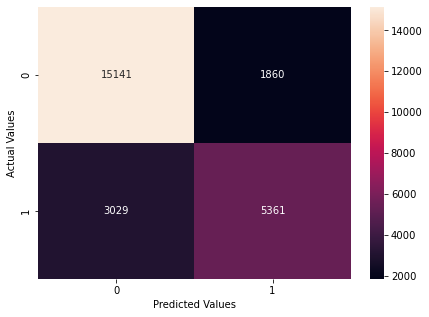

In [28]:
cm = confusion_matrix(y_train, pred_train)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="g")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

#### Observations (Final Model)
- Here we can see our final model with all multicolliuniarity and high p-value columns removed.  
- The training performance did not change much (accuracy,recall, precision, F1) which is a great indicator that the variables removed did not have much effect on the model. 
- However the performance measures also didn't increase, so we need to attempt different threshold values in order to improve these measures  (using ROC and precision-recall curves)

####  Converting coefficients to odds
* The coefficients of the logistic regression model are in terms of log(odd), to find the odds we have to take the exponential of the coefficients. 
* Therefore, **odds =  exp(b)**
* The percentage change in odds is given as **odds = (exp(b) - 1) * 100**

In [29]:
# converting coefficients to odds
odds = np.exp(lg.params)

# finding the percentage change
perc_change_odds = (np.exp(lg.params) - 1) * 100

# removing limit from number of columns to display
pd.set_option("display.max_columns", None)

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=x_train3.columns).T

,const,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,repeated_guest,no_of_previous_cancellations,avg_price_per_room,no_of_special_requests,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Corporate,market_segment_type_Offline
Odds,0.00000,1.12464,1.17204,1.15363,1.04483,0.19321,1.01589,1.57488,0.95323,0.10830,1.25098,1.01937,0.22193,1.14976,1.30507,0.67109,0.76317,0.46118,0.36733,0.23662,0.45349,0.16678
Change_odd%,-100.00000,12.46388,17.20438,15.36325,4.48281,-80.67859,1.58947,57.48846,-4.67705,-89.17026,25.09776,1.93721,-77.80747,14.97615,30.50707,-32.89068,-23.68300,-53.88173,-63.26741,-76.33763,-54.65113,-83.32239


#### Observations 
- Here we can see how much incremental (single value) changes in our predictors would influnece the probability change for our results. 
  - For example, if the number of adults in a booked room increases by one, the probability of them canceling their booking goes up by 12.46%

In [30]:
#Here are the 4 metrics used to evaluate the performance
log_reg_model_train_perf = model_performance_classification_statsmodels(
    lg, x_train3, y_train, threshold=0.5
)
print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.80745,0.63897,0.74242,0.68682


#### Use ROC-AUC curve to find optimal threshold
- ROC-AUC on training set

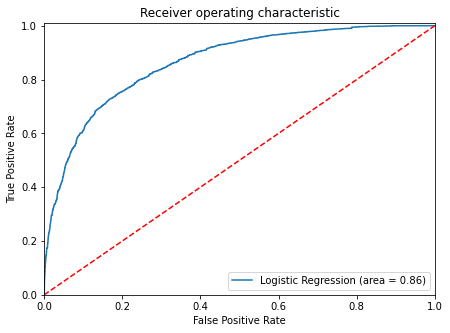

In [31]:
#This code builds a ROC curve that helps us estimate the ideal threshold to use in our model. 
logit_roc_auc_train = roc_auc_score(y_train, lg.predict(x_train3))
fpr, tpr, thresholds = roc_curve(y_train, lg.predict(x_train3))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [32]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = roc_curve(y_train, lg.predict(x_train3))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(round(optimal_threshold_auc_roc, 6))

0.387324


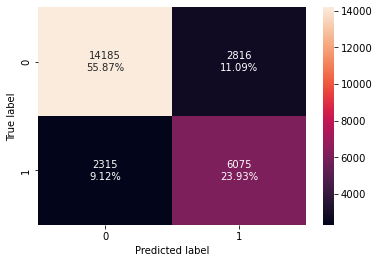

In [33]:
# creating confusion matrix with the optimal threshhold of 0.38
confusion_matrix_statsmodels(lg, x_train3, y_train, threshold=0.39)

In [34]:
# checking model performance for this model
log_reg_model_train_perf_threshold_auc_roc = model_performance_classification_statsmodels(
    lg, x_train3, y_train, threshold=0.39
)
print("Training performance:")
log_reg_model_train_perf_threshold_auc_roc

Training performance:


,Accuracy,Recall,Precision,F1
0,0.79792,0.72408,0.68328,0.70308


#### Let's use Precision-Recall curve and see if we can find a better threshold

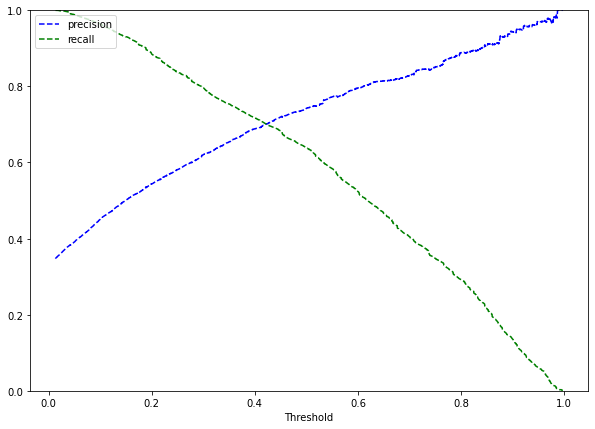

In [35]:
#This code builds a Precision-Recall curve function
y_scores = lg.predict(x_train3)
prec, rec, tre = precision_recall_curve(y_train, y_scores)

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

#### Observation
- Optimal threshhold calculated as 0.42 by precision recall curve

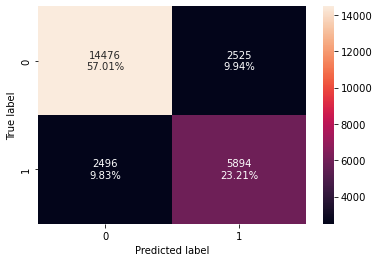

In [36]:
# creating confusion matrix
confusion_matrix_statsmodels(lg, x_train3, y_train, threshold=0.42)

In [37]:
log_reg_model_train_perf_threshold_curve = model_performance_classification_statsmodels(
    lg, x_train3, y_train, threshold=0.42
)
print("Training performance:")
log_reg_model_train_perf_threshold_curve

Training performance:


,Accuracy,Recall,Precision,F1
0,0.80225,0.70250,0.70008,0.70129


#### Observations
- After calculating the ideal threshhold of 0.39 with the ROC curve and 0.42 with the precision-recall curve, we can see that each threshhold returns different Accuracy, Recall, Precision and F1 values.  They are not drastically different. 
- The ROC curve achieves a higher recall value but the precision-recall curve achieves a higher precision value.  The other measures are close to the same. choice of model depends on the business goals. In this case all values matter as both false positives and negatives are damaging. Therefore, the threshhold of 0.42 from our ROC curve is best as it maximizes all measures of the model.

## Next we must check the performance of the ROC and precision-recall curve thresholds on the test set

#### Test confusion matrix on test data at 0.5 threshold

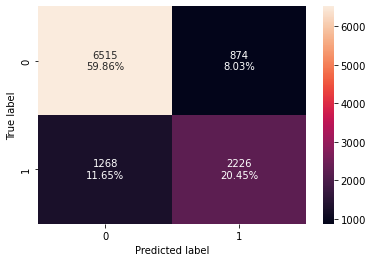

In [38]:
#Test confusion matrix on test data at 0.5 threshold
confusion_matrix_statsmodels(lg, x_test3, y_test, threshold=0.5)

In [39]:
log_reg_model_test_perf = model_performance_classification_statsmodels(
    lg, x_test3, y_test, threshold=0.5
)
print("Test performance:")
log_reg_model_test_perf 

Test performance:


,Accuracy,Recall,Precision,F1
0,0.80318,0.63709,0.71806,0.67516


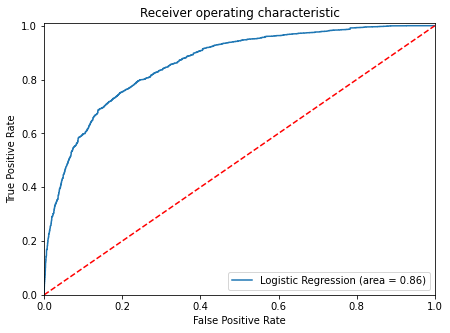

In [40]:
#ROC curve on test set
logit_roc_auc_test = roc_auc_score(y_test, lg.predict(x_test3))
fpr, tpr, thresholds = roc_curve(y_test, lg.predict(x_test3))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

#### Test confusion matrix on test data at 0.37 threshold

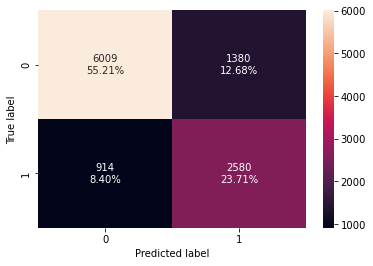

In [41]:
#Test confusion matrix on test data at 0.37 threshold
confusion_matrix_statsmodels(lg, x_test3, y_test, threshold=0.37)

In [42]:
log_reg_model_test_perf_threshold_auc_roc= model_performance_classification_statsmodels(
    lg, x_test3, y_test, threshold=0.37
)
print("Test performance:")
log_reg_model_test_perf 

Test performance:


,Accuracy,Recall,Precision,F1
0,0.80318,0.63709,0.71806,0.67516


In [43]:
#### Test confusion matrix on test data at 0.42 threshold

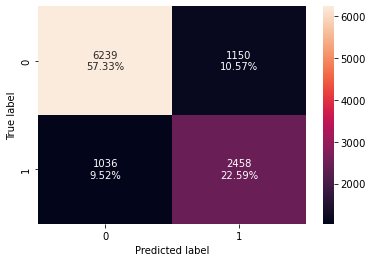

In [44]:
#Test confusion matrix on test data at 0.42 threshold
confusion_matrix_statsmodels(lg, x_test3, y_test, threshold=0.42)

In [45]:
log_reg_model_test_perf_threshold_curve = model_performance_classification_statsmodels(
    lg, x_test3, y_test, threshold=0.42
)
print("Test performance:")
log_reg_model_test_perf 

Test performance:


,Accuracy,Recall,Precision,F1
0,0.80318,0.63709,0.71806,0.67516


#### Model Performance Summary

In [46]:
# training performance comparison
models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression-default Threshold",
    "Logistic Regression-0.37 Threshold",
    "Logistic Regression-0.42 Threshold",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression-default Threshold,Logistic Regression-0.37 Threshold,Logistic Regression-0.42 Threshold
Accuracy,0.80745,0.79792,0.80225
Recall,0.63897,0.72408,0.70250
Precision,0.74242,0.68328,0.70008
F1,0.68682,0.70308,0.70129


In [47]:
# training performance comparison

models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf.T,
        log_reg_model_test_perf_threshold_auc_roc.T,
        log_reg_model_test_perf_threshold_curve.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression-default Threshold",
    "Logistic Regression-0.37 Threshold",
    "Logistic Regression-0.42 Threshold",
]

print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Logistic Regression-default Threshold,Logistic Regression-0.37 Threshold,Logistic Regression-0.42 Threshold
Accuracy,0.80318,0.78921,0.79914
Recall,0.63709,0.73841,0.70349
Precision,0.71806,0.65152,0.68126
F1,0.67516,0.69225,0.69220


#### Observations
- We can see that in the case of both the traning and testing sets, the accuracy, recall, precision, and F1 values vary based on the threshold. It is difficult to say which threshhold is the best as each has their strengths.  Due to the fact that both false positives and false negatives are important to avoid in this use case, we should select the models that maximize F1 value without drastically minimizing other values.
  - A threshold of 0.42 is likely the ideal choice here as it has strong F1 values for both the train and test data and maximizes other values as best as possible.
- Due to the fact both false positives and false negatives are important to our stkeholder, we can use the accuracy measure to determine the total percentage of correct choices.  That being said our accuracy measures had very little variation between threshold models. 

In [48]:
logit = sm.Logit(y_train, x_train3.astype(float)) 
lg = logit.fit() 
print(lg.summary()) 

Optimization terminated successfully.
         Current function value: 0.424139
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:         booking_status   No. Observations:                25391
Model:                          Logit   Df Residuals:                    25369
Method:                           MLE   Df Model:                           21
Date:                Tue, 30 May 2023   Pseudo R-squ.:                  0.3315
Time:                        09:54:03   Log-Likelihood:                -10769.
converged:                       True   LL-Null:                       -16110.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           -919.3880    121.224     -7.584    

## Building a Decision Tree model

- We want to predict which bookings will be canceled using a decision tree and see if we can build a model better than our logisitic regression.
- Before we proceed to build a model, we'll have to encode categorical features.
- We'll split the data into train and test to be able to evaluate the model that we build on the train data.

In [49]:
#Here we will create new x and y split with all variables included as decision trees have different way of dealing with useless variables compared with regressions 
X = data.drop(["booking_status"], axis=1)
Y = data["booking_status"]

X = pd.get_dummies(
    X, 
    columns=X.select_dtypes(include=['object','category']).columns.tolist(), 
    drop_first=True,
)

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [50]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (25391, 27)
Shape of test set :  (10883, 27)
Percentage of classes in training set:
0   0.66957
1   0.33043
Name: booking_status, dtype: float64
Percentage of classes in test set:
0   0.67895
1   0.32105
Name: booking_status, dtype: float64


#### First, let's create functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.
* The model_performance_classification_sklearn function will be used to check the model performance of models. 
* The confusion_matrix_sklearnfunction will be used to plot the confusion matrix.

In [51]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [52]:
#This function with create confusion matrix for decision tree results
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

#### Build your tree without pruning

In [53]:
#this code builds our first tree
model = DecisionTreeClassifier(criterion='gini', random_state=1)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

### THIS IS NOT THE FINAL TREE!
- This tree is simply an example of what a overfit decision tree looks like.

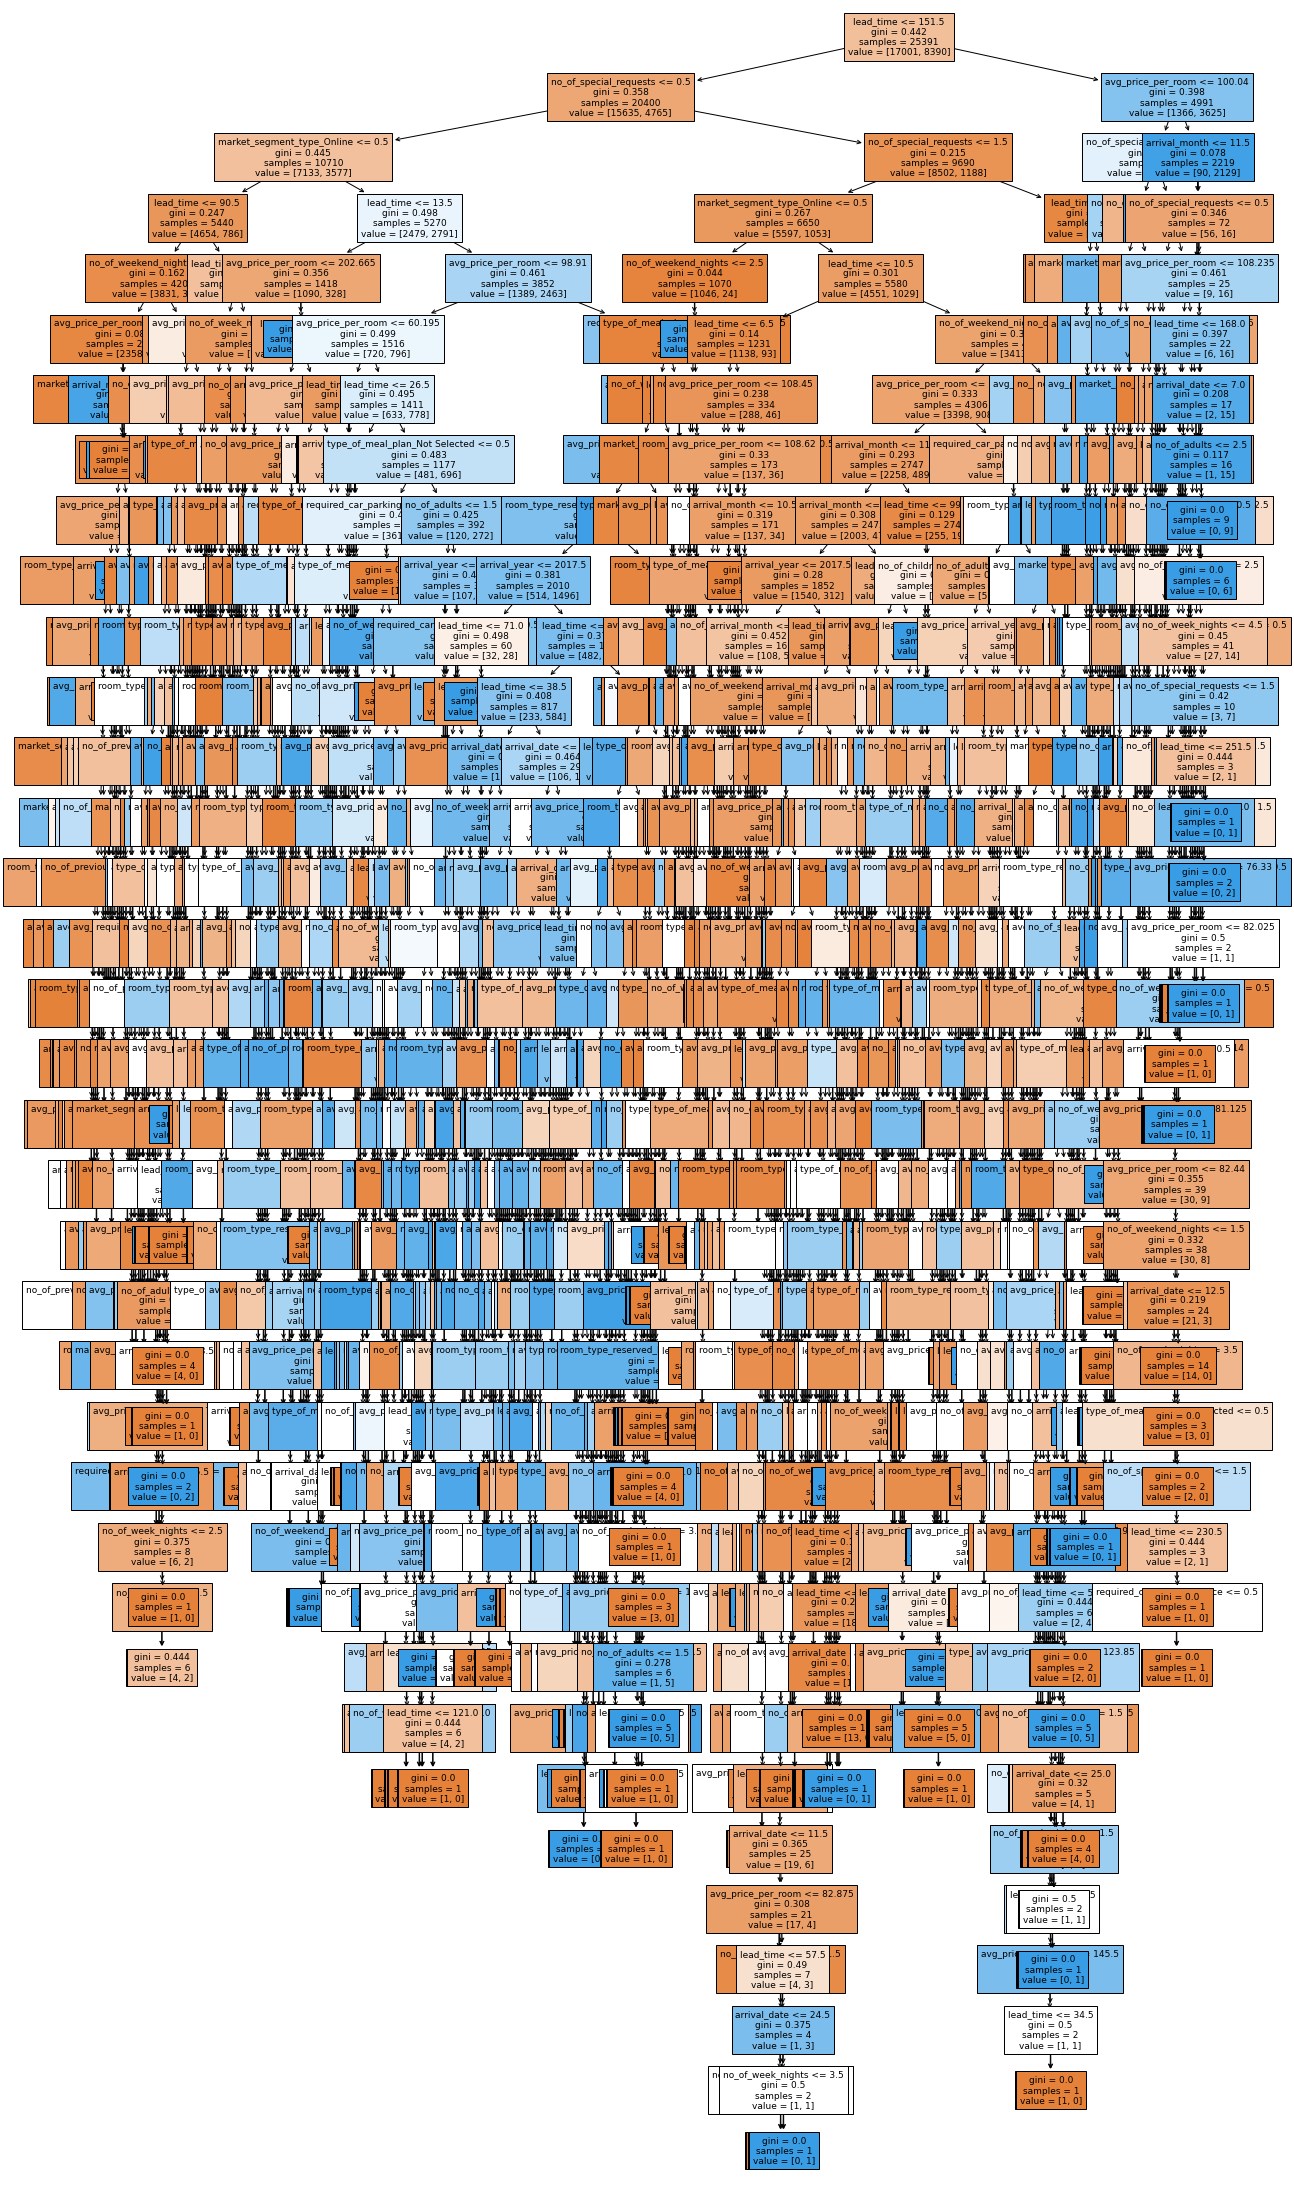

In [54]:
feature_names = list(X_train.columns)
plt.figure(figsize=(20, 40))
out = tree.plot_tree(model,feature_names=feature_names, filled=True, fontsize=9, node_ids=False, class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

#### Observations 
- This tree is far too complex to be useful. This is due to the lack of pruning and will likely be resolved once pruning is added.

#### Check model performance on Training Data

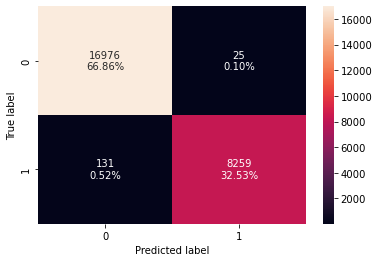

In [55]:
confusion_matrix_sklearn(model, X_train, y_train)

In [56]:
decision_tree_perf_train = model_performance_classification_sklearn(
    model, X_train, y_train
)
decision_tree_perf_train

,Accuracy,Recall,Precision,F1
0,0.99386,0.98439,0.99698,0.99064


#### Check model performance on Test Data

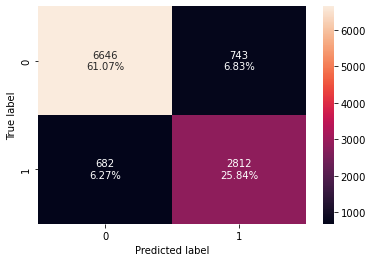

In [57]:
confusion_matrix_sklearn(model, X_test, y_test) 

In [58]:
decision_tree_perf_test = model_performance_classification_sklearn(model, X_test, y_test)
decision_tree_perf_test

,Accuracy,Recall,Precision,F1
0,0.86906,0.80481,0.79100,0.79784


#### Observations
- The preformance results of the training data decision tree model was impressive as there were no constraints on the tree. Therefore a great deal of overfit would be expected on the test data.
- Suprisingly the test data also performed well on the same model even though this model is likely overfit. The performance did drop but Accuracy, Recall, Precision, and F1 are all at or above 0.8 (higher than our best logistic regression model)
- It is concerning that the training and testing set values are so different from one another. In a strong model we want the results from training and testing to be close to one another.

#### Check important features before pruning the tree.

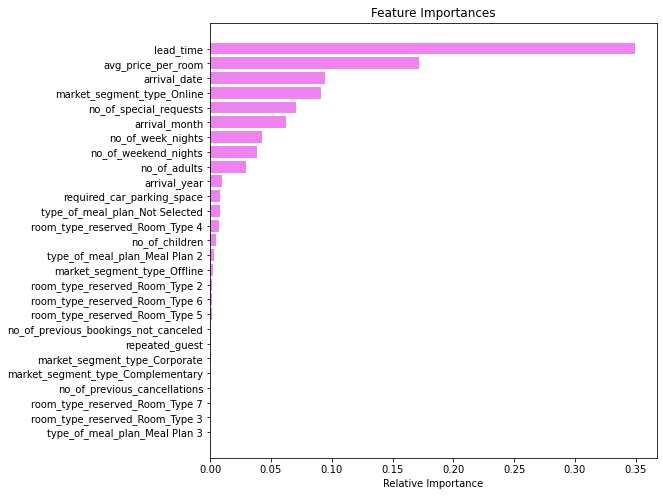

In [59]:
#This graph visualizes the most important predictor variables in your decision tree model.
feature_names = list(X_train.columns)
importances = model.feature_importances_
indices = np.argsort(importances)

#create barplot with 
plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Pruning the tree

**Pre-Pruning**

In [60]:
#This code finds ideal the Hyperparameters for the decison tree
# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=1, class_weight="balanced")

# Grid of parameters to choose from
parameters = {
    "max_depth": np.arange(2, 7, 2),
    "max_leaf_nodes": [50, 75, 150, 250],
    "min_samples_split": [10, 30, 50, 70],
}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=50,
                       min_samples_split=30, random_state=1)

#### Checking performance on training set

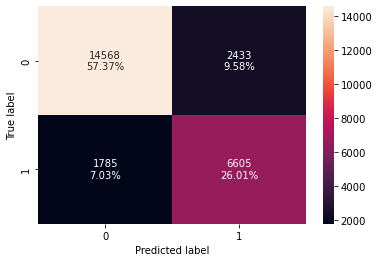

In [61]:
confusion_matrix_sklearn(estimator, X_train, y_train) 

In [62]:
decision_tree_tune_perf_train = model_performance_classification_sklearn(estimator, X_train, y_train) ## Complete the code to check performance on train set
decision_tree_tune_perf_train

,Accuracy,Recall,Precision,F1
0,0.83388,0.78725,0.73080,0.75798


#### Checking performance on training set

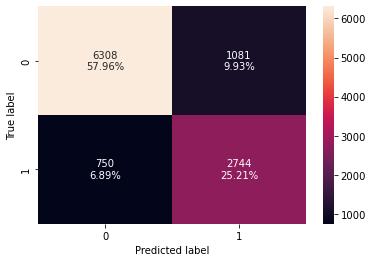

In [63]:
confusion_matrix_sklearn(estimator, X_test, y_test) 

In [64]:
decision_tree_tune_perf_test = model_performance_classification_sklearn(estimator, X_test, y_test) ## Complete the code to check performance on train set
decision_tree_tune_perf_test

,Accuracy,Recall,Precision,F1
0,0.83176,0.78535,0.71739,0.74983


#### Observations
- After finding the ideal hyperparameters and factoring them into the tree model, we can see that the results of the training data dropped significantly. This is ok as that is to be expected when setting hyperparameters that hopefully reduce overfitting.  
- The issue here is that the test data results when using the model with hyperparameters are also lower than our original model with overfitting assumed. 
- The fact that the training and testing values are almost the same is the best indicator that this model is better than the first.  Although it may seem that the scores are lower, because the train and test results are almost the same, we can assume that this model is more accurate on a variety of different data sets. 
- This model already outperforms all of our regression models.

### Visualize the Tree Pruned with Hyperparameters

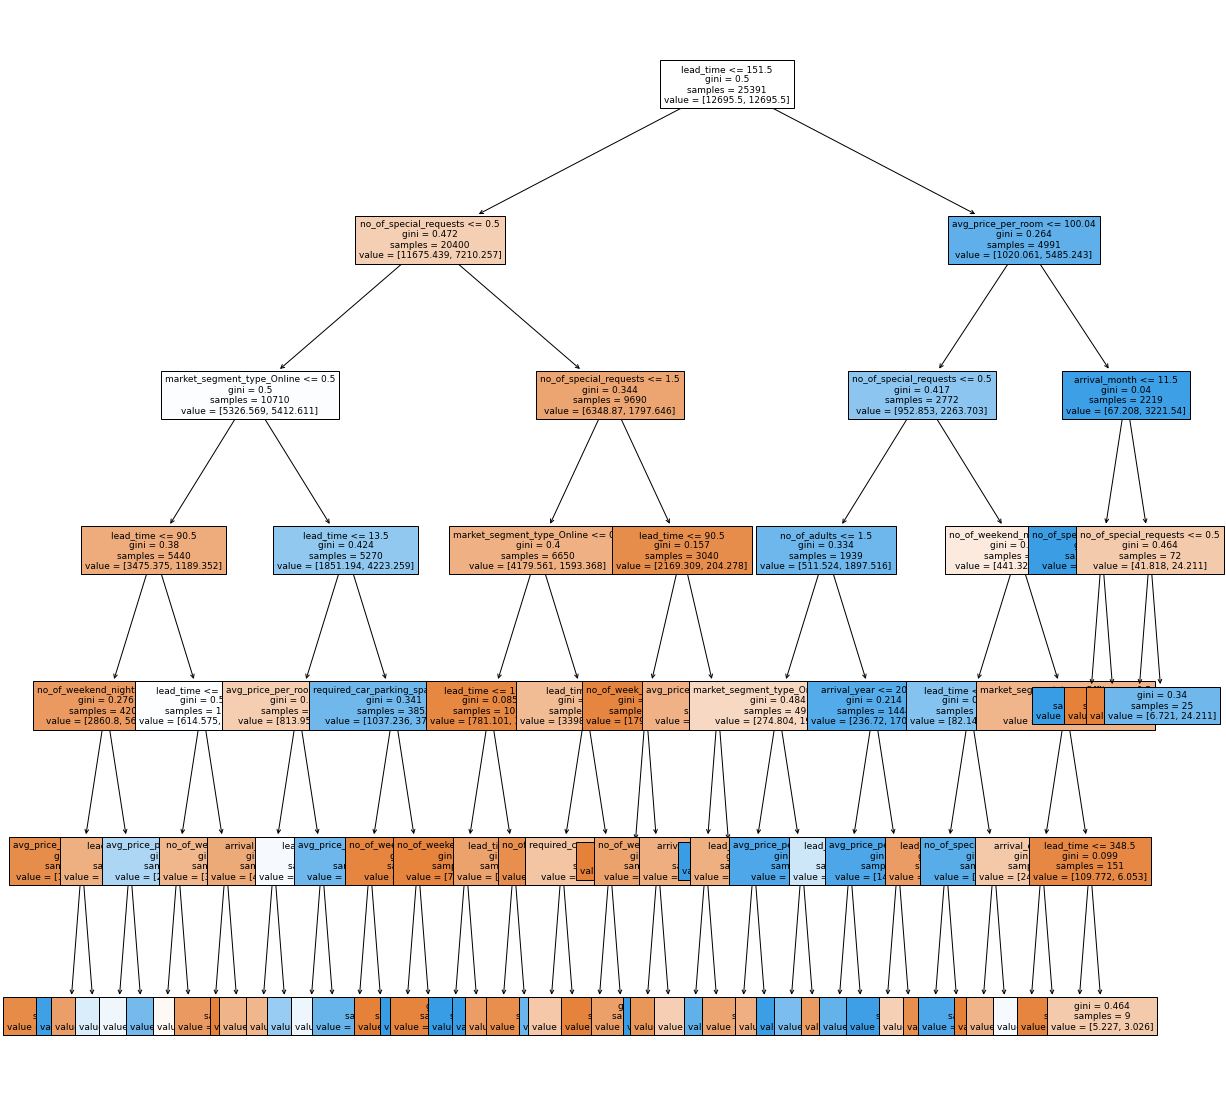

In [65]:
plt.figure(figsize=(20, 20))
out = tree.plot_tree(estimator,feature_names=feature_names, filled=True, fontsize=9, node_ids=False, class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [66]:
# Text report showing the rules of a decision tree -
print(tree.export_text(estimator, feature_names=feature_names, show_weights=True))

|--- lead_time <= 151.50
|   |--- no_of_special_requests <= 0.50
|   |   |--- market_segment_type_Online <= 0.50
|   |   |   |--- lead_time <= 90.50
|   |   |   |   |--- no_of_weekend_nights <= 0.50
|   |   |   |   |   |--- avg_price_per_room <= 196.50
|   |   |   |   |   |   |--- weights: [1760.09, 143.75] class: 0
|   |   |   |   |   |--- avg_price_per_room >  196.50
|   |   |   |   |   |   |--- weights: [0.75, 22.70] class: 1
|   |   |   |   |--- no_of_weekend_nights >  0.50
|   |   |   |   |   |--- lead_time <= 65.50
|   |   |   |   |   |   |--- weights: [954.35, 220.92] class: 0
|   |   |   |   |   |--- lead_time >  65.50
|   |   |   |   |   |   |--- weights: [145.62, 178.55] class: 1
|   |   |   |--- lead_time >  90.50
|   |   |   |   |--- lead_time <= 116.50
|   |   |   |   |   |--- avg_price_per_room <= 93.58
|   |   |   |   |   |   |--- weights: [203.12, 220.92] class: 1
|   |   |   |   |   |--- avg_price_per_room >  93.58
|   |   |   |   |   |   |--- weights: [78.41, 263.29] 

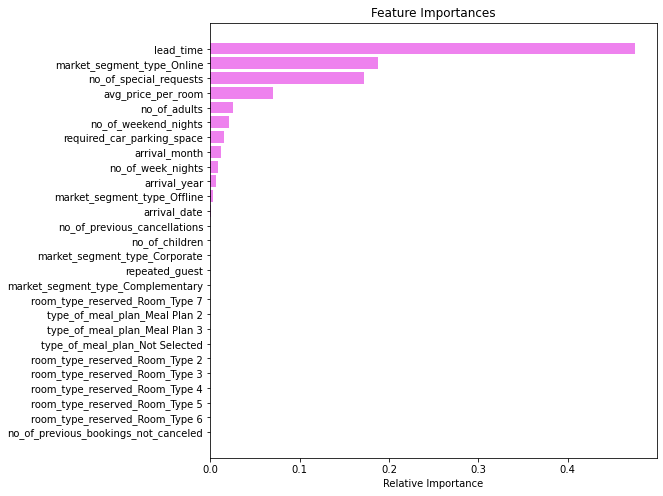

In [67]:
# importance of features in the tree building
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Cost-Complexity Pruning
- Cost complexity pruning provides another option to control the size of a tree. In DecisionTreeClassifier, this pruning technique is parameterized by the cost complexity parameter (alpha). Greater values of alpha increase the number of nodes pruned. 

In [68]:
#The ccp_alpha value 
clf = DecisionTreeClassifier(random_state=1, class_weight="balanced", ccp_alpha=0.004)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = abs(path.ccp_alphas), path.impurities

In [69]:
pd.DataFrame(path)

,ccp_alphas,impurities
0,0.00000,0.00852
1,0.00000,0.00852
2,0.00000,0.00852
3,0.00000,0.00852
4,0.00000,0.00852
...,...,...
1731,0.00820,0.32635
1732,0.00974,0.33610
1733,0.01318,0.34928
1734,0.03479,0.41886


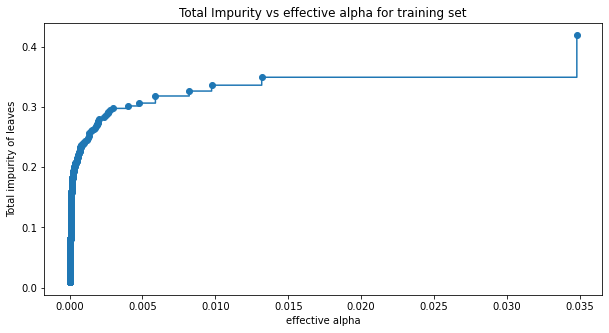

In [70]:
#this chart looks at the realtionship between alpha and the imurity of leaves
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

Next, we train a decision tree using effective alphas. The last value
in ``ccp_alphas`` is the alpha value that prunes the whole tree,
leaving the tree, ``clfs[-1]``, with one node.

In [71]:
#This code calculates the number of leaves in the model with ccp alphas 
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, class_weight="balanced", ccp_alpha=0.004)
    clf.fit(X_train,y_train) 
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1])
)

Number of nodes in the last tree is: 21 with ccp_alpha: 0.08114238675403901


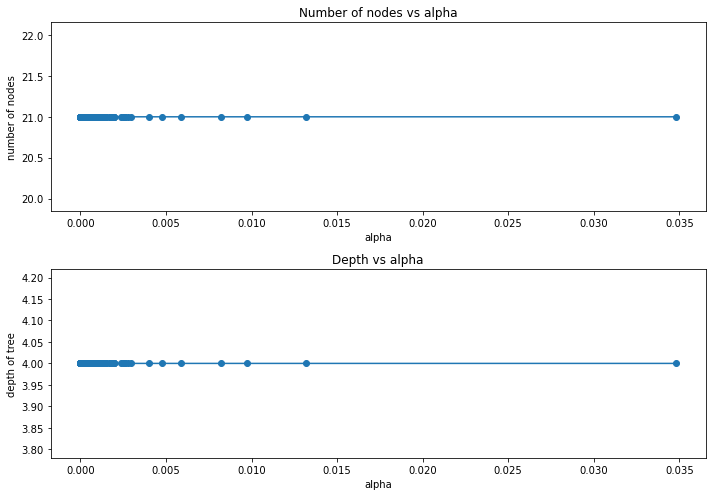

In [72]:
#this chart looks at the realtionship between alphaand number of nodes as well as depth 
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

#### F1 Score vs alpha for training and testing sets

In [73]:
f1_train = []
for clf in clfs:
    pred_train = clf.predict(X_train)
    values_train = f1_score(y_train, pred_train)
    f1_train.append(values_train)

f1_test = []
for clf in clfs:
    pred_test = clf.predict(X_test)
    values_test = f1_score(y_test, pred_test)
    f1_test.append(values_test)

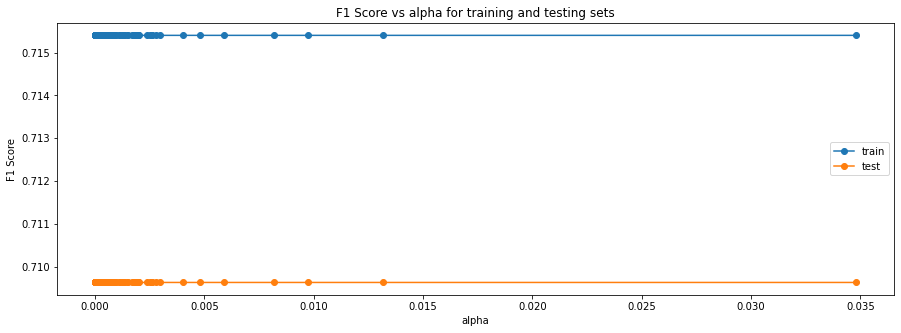

In [74]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("F1 Score")
ax.set_title("F1 Score vs alpha for training and testing sets")
ax.plot(ccp_alphas, f1_train, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, f1_test, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

#### Observations
- There is something strange going on here. 
- We would expect alpha to decrease fror training data and the F1 score decreases as overfitting is removed. This is not the relationship we see on the chart. in fact we see no real relationship on the chart.  
- This change occured when we input ccp_alpha=0.004 as an argument for our decision tree. The value of 0.004 was selected from our previous chart of F1 vs. alpha and was the alpha value at which the two lines diverged.  After adjusting the model with this argument, that patter no longer exists, but our accuracy, recall, precision, and F1 values for the model have all imporved, therefore we are going to keep it as is despite the chart. 

In [75]:
index_best_model = np.argmax(f1_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.004, class_weight='balanced', random_state=1)


#### Checking performance on Training and Testing sets

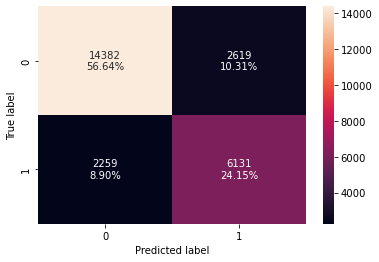

In [76]:
#Training set
confusion_matrix_sklearn(best_model, X_train, y_train)

In [77]:
decision_tree_post_perf_train = model_performance_classification_sklearn(best_model, X_train, y_train)
decision_tree_post_perf_train    

,Accuracy,Recall,Precision,F1
0,0.80788,0.73075,0.70069,0.71540


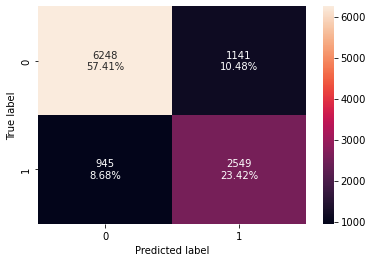

In [78]:
#Testing Set
confusion_matrix_sklearn(best_model, X_test, y_test)

In [79]:
decision_tree_post_perf_test = model_performance_classification_sklearn(best_model, X_test, y_test)
decision_tree_post_perf_test

,Accuracy,Recall,Precision,F1
0,0.80832,0.72954,0.69079,0.70963


#### Observations 
- The results are decent however most did not exceed the prepruning model on either train or test data therefore the prepruning model is still the best so far. 
- The graphs here dont follow the typical patterns of successful prepruning model however you cant argue with the improved train and test data results.

### Visualize the best tree

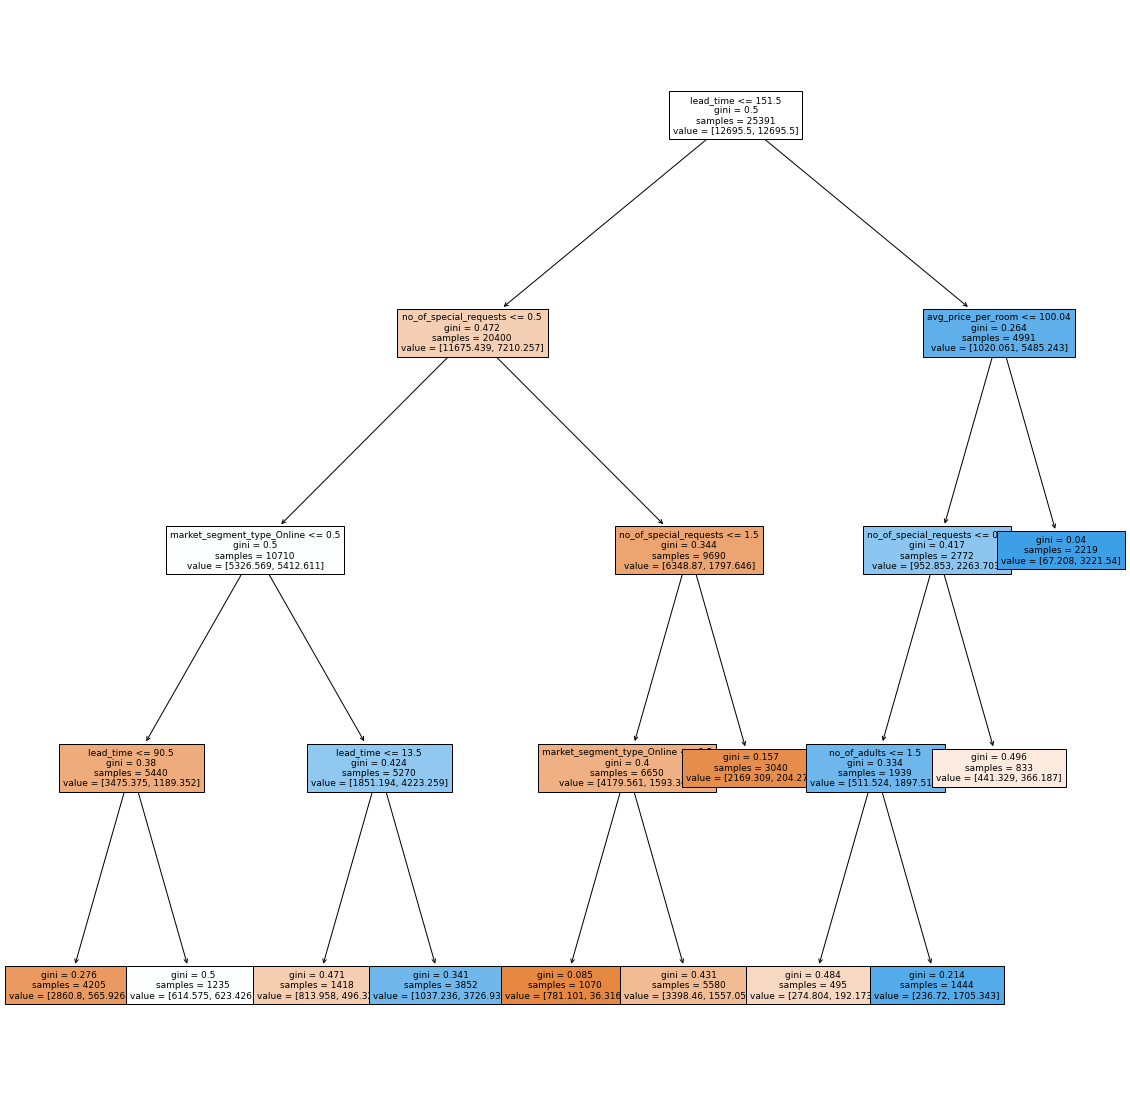

In [80]:
#plot the tree
plt.figure(figsize=(20, 20))

out = tree.plot_tree(
    best_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [81]:
# Text report showing the rules of a decision tree -
print(tree.export_text(best_model, feature_names=feature_names, show_weights=True))

|--- lead_time <= 151.50
|   |--- no_of_special_requests <= 0.50
|   |   |--- market_segment_type_Online <= 0.50
|   |   |   |--- lead_time <= 90.50
|   |   |   |   |--- weights: [2860.80, 565.93] class: 0
|   |   |   |--- lead_time >  90.50
|   |   |   |   |--- weights: [614.58, 623.43] class: 1
|   |   |--- market_segment_type_Online >  0.50
|   |   |   |--- lead_time <= 13.50
|   |   |   |   |--- weights: [813.96, 496.32] class: 0
|   |   |   |--- lead_time >  13.50
|   |   |   |   |--- weights: [1037.24, 3726.94] class: 1
|   |--- no_of_special_requests >  0.50
|   |   |--- no_of_special_requests <= 1.50
|   |   |   |--- market_segment_type_Online <= 0.50
|   |   |   |   |--- weights: [781.10, 36.32] class: 0
|   |   |   |--- market_segment_type_Online >  0.50
|   |   |   |   |--- weights: [3398.46, 1557.05] class: 0
|   |   |--- no_of_special_requests >  1.50
|   |   |   |--- weights: [2169.31, 204.28] class: 0
|--- lead_time >  151.50
|   |--- avg_price_per_room <= 100.04
|   |  

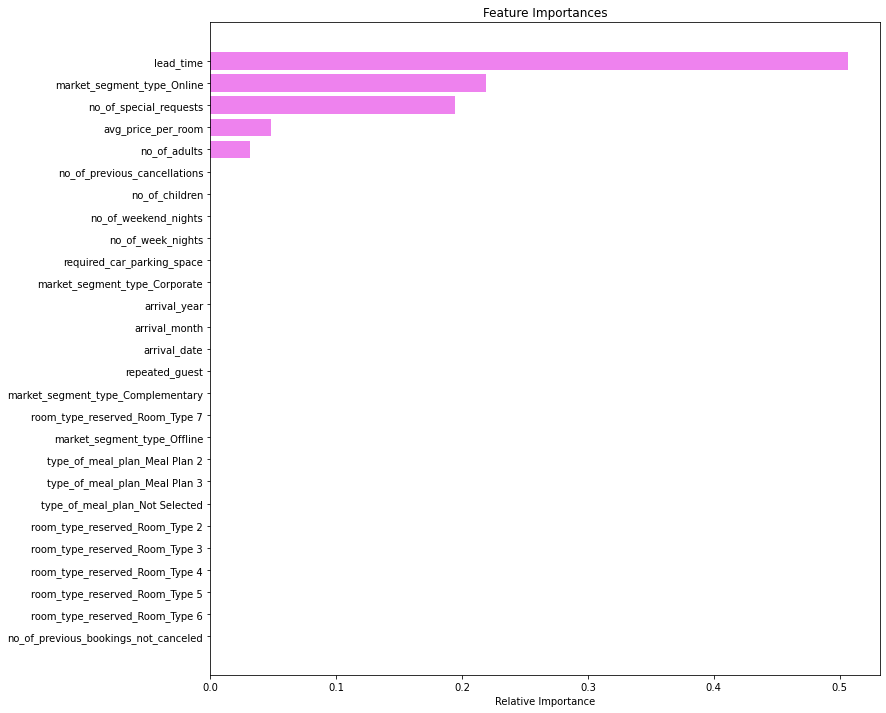

In [82]:
#visualize the important features of the model
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

#### Comparing Decision Tree models

In [83]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        decision_tree_perf_train.T,
        decision_tree_tune_perf_train.T,
        decision_tree_post_perf_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree sklearn",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree sklearn,Decision Tree (Pre-Pruning),Decision Tree (Post-Pruning)
Accuracy,0.99386,0.83388,0.80788
Recall,0.98439,0.78725,0.73075
Precision,0.99698,0.73080,0.70069
F1,0.99064,0.75798,0.71540


In [84]:
# Testing performance comparison
models_test_comp_df = pd.concat(
    [
        decision_tree_perf_test.T,
        decision_tree_tune_perf_test.T,
        decision_tree_post_perf_test.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree sklearn",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
]
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Decision Tree sklearn,Decision Tree (Pre-Pruning),Decision Tree (Post-Pruning)
Accuracy,0.86906,0.83176,0.80832
Recall,0.80481,0.78535,0.72954
Precision,0.79100,0.71739,0.69079
F1,0.79784,0.74983,0.70963


## Model Performance Comparison and Conclusions

- While the first model with no pre or post pruning has very high scores on training data but not test data, indicating massive overfitting and a poor model.  This also makes sense looking at the visual of our initial tree as it is massive and busy, indicating overfitting and a bad model. 
- The Prepruning scores for training and test data are very close to one another, indicating this is a much better model without overfitting.  
- The training and test scores for the postpruning tree are very close to one another, indicating this is a much better model without overfitting however the scores are slightly lower than the prepruning tree.

The prepruning tree is the best model of the three as its scores for train and test data are all within 2% of one another and the socres are higher than the post-pruning model meaning it has less total incorrect classifications.  

## Actionable Insights and Recommendations

- What profitable policies for cancellations and refunds can the hotel adopt?
- What other recommedations would you suggest to the hotel?

In [85]:
# converting coefficients to odds
odds = np.exp(lg.params)

# finding the percentage change
perc_change_odds = (np.exp(lg.params) - 1) * 100

# removing limit from number of columns to display
pd.set_option("display.max_columns", None)

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=x_train3.columns).T

,const,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,repeated_guest,no_of_previous_cancellations,avg_price_per_room,no_of_special_requests,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Corporate,market_segment_type_Offline
Odds,0.00000,1.12464,1.17204,1.15363,1.04483,0.19321,1.01589,1.57488,0.95323,0.10830,1.25098,1.01937,0.22193,1.14976,1.30507,0.67109,0.76317,0.46118,0.36733,0.23662,0.45349,0.16678
Change_odd%,-100.00000,12.46388,17.20438,15.36325,4.48281,-80.67859,1.58947,57.48846,-4.67705,-89.17026,25.09776,1.93721,-77.80747,14.97615,30.50707,-32.89068,-23.68300,-53.88173,-63.26741,-76.33763,-54.65113,-83.32239


#### Conclusions

**Logistic Regression**
- no_of_adults:The odds of cancellation decrease by 12.46% for each additional adult in the booking.
- no_of_children: The odds of cancellation increase by 17.20% for each additional child in the booking.
- no_of_weekend_nights:The odds of cancellation increase by 15.36% for each additional weekend night in the booking.
- no_of_week_nights: The odds of cancellation increase by 4.48% for each additional weeknight in the booking.
- required_car_parking_space:The odds of cancellation increase by 80.68% if a car parking space is required.
- lead_time:For each additional day of lead time, the odds of cancellation increase by 1.59%.
   - While this may not seem like much, this is for each day therefore a additional week of lead time leads to a 11.2% increased chance of cancelation, which is significant.  
- arrival_year:The odds of cancellation increase by 57.49% for each additional year of arrival.
- repeated_guest:The odds of cancellation decrease by 89.17% for a repeated guest.
- no_of_previous_cancellations:The odds of cancellation increase by 25.10% for each previous cancellation.
- avg_price_per_room:The odds of cancellation increase by 1.94% for each increase in the average price per room.
- no_of_special_requests:The odds of cancellation increase by 77.81% for each additional special request.
- type_of_meal_plan_Meal Plan 2:The odds of cancellation increase by 14.98% for bookings with Meal Plan 2.
- type_of_meal_plan_Not Selected:The odds of cancellation increase by 30.51% for bookings with no meal plan selected.
- market_segment_type_Corporate:The odds of cancellation decrease by 54.65% for bookings in the corporate market segment.
- market_segment_type_Offline: The odds of cancellation decrease by 83.32% for bookings in the offline market segment.

These findings can be used by hotel executives and marketing staff to target customer segments less likely to cancel booksings (smaller groups or individuals without kids, repeat customers, corporate and offline market segments, those whoe book a parti. etc.) and others are more likely to cancel (those who have canceled beofore, customers with lots of special requests, etc)

We can also draw other conclusions such as the fact that customers are increasingly likely to cancel bookings as the years go on. In fact this data says that booking cancelations went up by more than 50% year over year! This should be investigated further. 


**Decison Trees**
- Our prepruned tree (best model) can predict 78.5% of cancelations correctly
- Lead time,the online marget segment, number of special requests, and room price are all important variables in determining if a customer will cancel or not. The company should focus on what they can do to 
- As the variable used vary with the type of node selections the INN should build seperate models for each leg of the tree to better pin down which customers will cancel in every particular situation. 

Due to this information and the graph below we can recommend the hotel di its best to prevent customers from booking too far in advance as they are pron to cancelation. An alternative would be to trarget scustomers who have trips coming in the short term or create a policy that allows customers to easily change their hotel requirements without full cancelation. 




<AxesSubplot:xlabel='booking_status', ylabel='lead_time'>

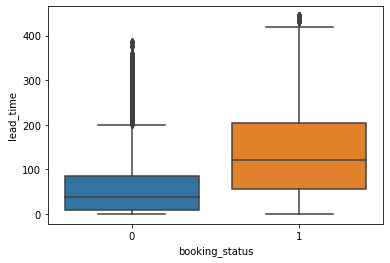

In [86]:
sns.boxplot(x=data['booking_status'], y=data['lead_time'])